The plan of this approach is to preprocess the image to display all of the lines as clearly and coherent as possible, while also removing any noise interference, so that the Hough Lines function can be employed to detect them.

In [41]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize

from IPython.display import display
import PIL

from itertools import combinations
from collections import defaultdict
from matplotlib import colormaps

Firstly, a basic way of reading the data, with basic preprocessing to make the picture more clear. Particularly, we decided to manipulate each column in the image to have the same median, which turned out to be a good way to omit the noise that was often forming vertical lines (due to for example some parts of the road transfering vibrations better or worse)

In [42]:
path_out = 'mateusz\\'
files = glob.glob(path_out+"*")
files.sort()

dx= 5.106500953873407
dt= 0.0016

data = []

first_filename = files[0]
for f in files[:6]:
    data.append(np.load(f))
      
data = np.concatenate(data)
time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

columns = np.arange(len(data[0])) * dx

df = pd.DataFrame(data=data, index=index, columns=columns)

df -= df.mean()
df = np.abs(df)

arr = np.array(df)
arr_origin = np.copy(arr)

arr_btrCol = np.copy(arr)
arr_btrCol = arr + np.median(arr) - np.median(arr, axis=0)
arr = arr_btrCol

low, high = np.percentile(df, [3, 99])
arr[arr > high] = high
arr[arr < low] = low

Here we have basic functions to process and show the picture. We will use them to present the results, but also to transform the image so it is easier to work with later.

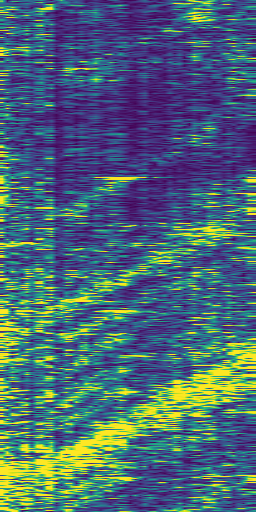

In [ ]:
# Just show the picture, can show more than one picture next to each other
def imshow1(img, num=1):
    display(PIL.Image.fromarray(cv2.resize(img, (256*num, 512), interpolation=cv2.INTER_LINEAR)))

# Show and/or process the image
def imshow(img, show=True, num_img=1, normalise=True):
    if normalise:
        img = np.float32(img)
        img = img - np.min(img)
        low, high = np.percentile(img, [3, 90])
        img *= 255 / high
    # cut from top values
    img[img > 255] = 255

    img = np.floor(img)
    img = np.uint8(img)
    # change to more convenient shape
    img = cv2.resize(img, (256 * num_img, 512), interpolation=cv2.INTER_LINEAR)

    if show:
        display(PIL.Image.fromarray(img))
    else:
        return img

# change to more convenient and readable colormap
def to_color(img):
    img = img / 255.0
    cmap = colormaps['viridis']
    img = (np.floor(cmap(img)[:, :, :3] * 255.0)).astype(np.uint8)
    return img

# Here we first process the image so that it can be changed to colormap, and then use the imshow to actually display it
def show_in_col(img, num=1):
    imshow1(to_color(imshow(img, show=False)), num=num)

show_in_col(arr_origin)

Now we can really start the processing

Firstly we blur the image so that some part of the noise is filtered and the lines we are interested in are more connected. Due to the shape of the image and to focus on detecting horizontal lines we blur with vertical kernels.

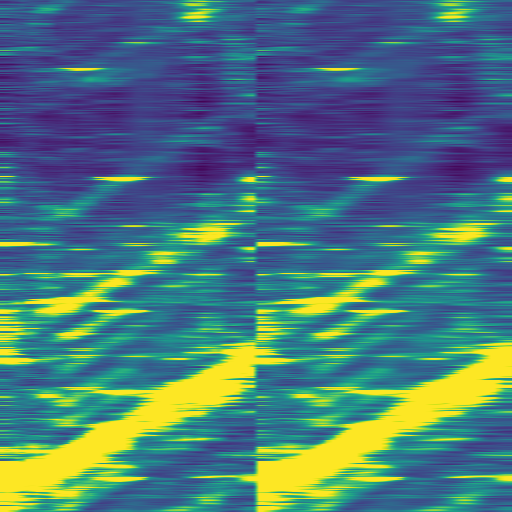

In [50]:
kernel_size = (51, 5)
kernel = np.ones((kernel_size[0],kernel_size[1])) / (kernel_size[0]*kernel_size[1])
arr_blurred = cv2.filter2D(arr, kernel=kernel, ddepth=-1)

kernel_size = (11, 3)
kernel = np.ones((kernel_size[0],kernel_size[1])) / (kernel_size[0]*kernel_size[1])
arr_blurred2 = cv2.filter2D(arr_blurred, kernel=kernel, ddepth=-1)

show_in_col(np.concatenate([arr_blurred, arr_blurred2], axis=1), num=2)

The difference between these images is hardly visible, but from our experiments turns out the double blurred image is more useful.

After some experiments we settled that it is a good moment to start detecting the edges, which may be useful to see where are the lines.

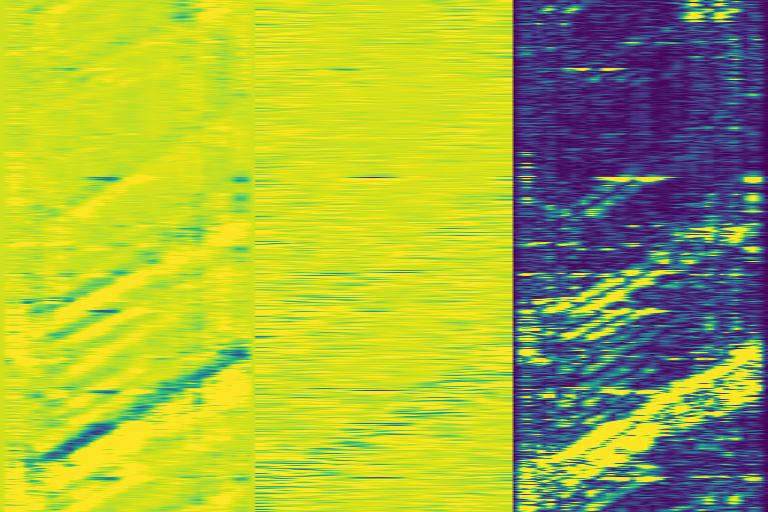

In [58]:
sobel_x = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
img_sobel_x = cv2.filter2D(arr_blurred, -1, sobel_x)
img_sobel_y = cv2.filter2D(arr_blurred, -1, sobel_y)
img_sobel = np.hypot(img_sobel_x, img_sobel_y)

show_in_col(np.concatenate([imshow(img_sobel_x, False), imshow(img_sobel_y, False), imshow(img_sobel, False)], axis=1), num=3)

Sobel on x and full one looked promising, but these methods turned out not to be very useful. Probably because they did not filter the noise and did not make the lines stand out as well as we needed.

We also tried laplacian filter with a little different results.

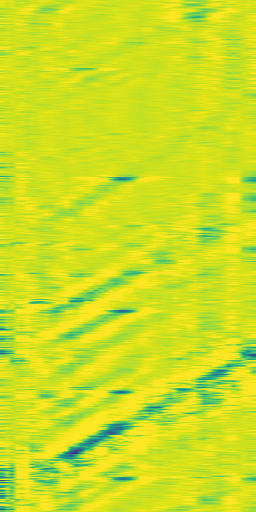

In [61]:
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
img_lapl = cv2.filter2D(arr_blurred2, -1, laplacian)

show_in_col(img_lapl)

In fact, the result looks quite like the Sobel x filter, but it had better perfomance later.

We also tried frequency domain filters and blurring the filtered images, but the results were not useful nor iteresting.

After these tests we decided it is a good moment to perform thresholding.

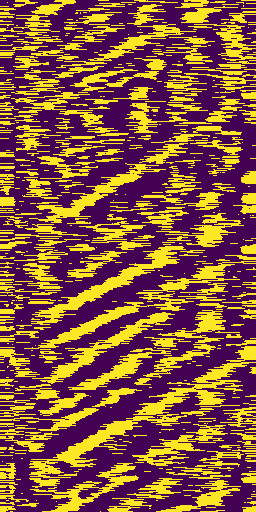

In [62]:
# change the size of the image, normalise the values
img = imshow(img_lapl, False)

# thresholding with inverse so that the lines have big values and the rest is 0
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 2)

show_in_col(img)

Although this image may seem confusing at first, we realised that while the lines we want to detect are quite wide, the noise forms some thin, torn structures. In this case it is obvious we should erode the image.

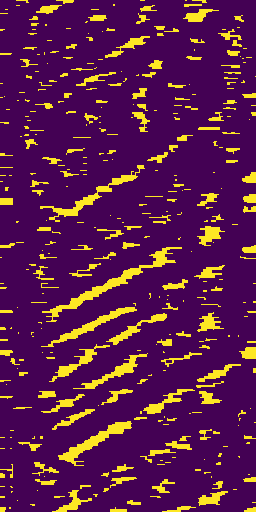

In [63]:
struct = np.ones((3, 3), np.uint8)
img = cv2.erode(img, struct, iterations=1)

show_in_col(img)

After applying the standard erosion algorithm we the lines seem more promising.

Now we can use it to detect the lines with Hough lines algorithm. Beacause detecting them in such an image is hard and somewhat prone to noise, we had to run this algorithm a few times, with different parameters and use all of the lines we got this way.

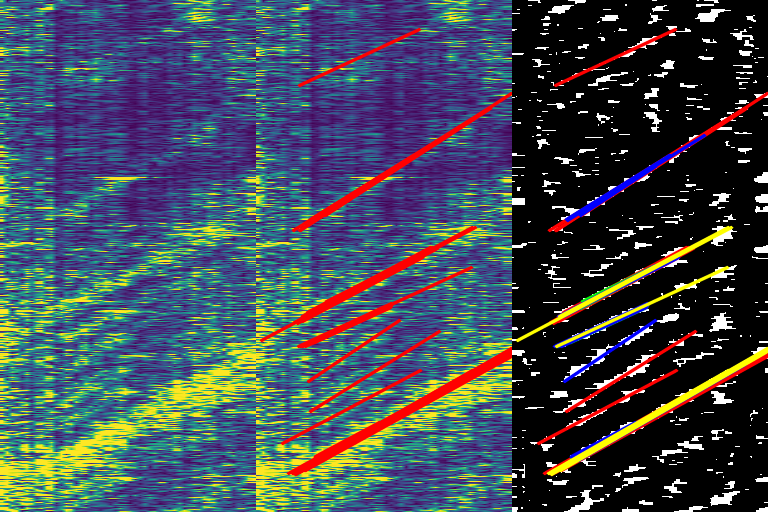

In [ ]:
def draw_lines(img, arr_): # The function takes an additional argument - simply to be able to put the original img in comparison
    c_test_img_p = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    arr = imshow(arr_, show=False)
    arr = to_color(arr)

    # These parameters were found by experimenting on many different pictures to make sure we do not overfit
    # Maybe in this example not all of them are required, but in the broader spectrum of images this is as good as we could possibly find
    hough_params = [
        (80, 120, 15, (255, 0, 0)),
        (100, 70, 3, (0, 255, 0)),
        (130, 60, 7, (0, 0, 255)),
        (150, 120, 20, (255, 255, 0))
    ]
    
    for params in hough_params:
        linesP = cv2.HoughLinesP(img, 1, np.pi / 180, params[0], None, params[1], params[2])
        if linesP is not None:
            for i in range(len(linesP)):
                l = linesP[i][0]
                # Draw the lines - each set of parameters gives differently colored line
                cv2.line(c_test_img_p, (l[0], l[1]), (l[2], l[3]), params[3], 2, cv2.LINE_AA)
                cv2.line(arr, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 2, cv2.LINE_AA)
            
    imshow1(np.concatenate([to_color(imshow(arr_, show=False)), arr, c_test_img_p], axis=1), 3)

draw_lines(img, arr_origin)

With this combination we can find practically all the lines. Unfortunately they often end up in similar places, which gives us a wrong number of their total count and makes it harder to estimate their speed.

We had to create and apply an algorithm to cluster all similar lines (based on their distance and tilt) to merge them on whole their length.

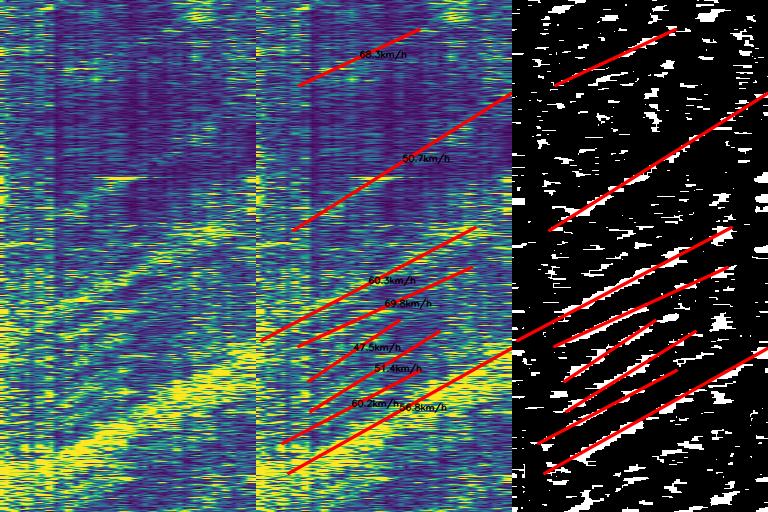

In [ ]:
# Checking the slope of the line
def rad_slope(line):
    x1, y1, x2, y2 = line
    if x1 > x2:
        d = x1
        x1 = x2
        x2 = d

        d = y1
        y1 = y2
        y2 = d
    elif x1 == x2:
        return np.pi / 2

    return np.arctan((y2 - y1) / (x2 - x1))

# Difference between slopes is not so easy to check, so we created this function
def dis(a, b):
    return min(abs(a - b), min(abs(np.pi / 2 - a), abs((-np.pi / 2) - a)) + min(abs(np.pi / 2 - b), abs((-np.pi / 2) - b)))

# Approximating distance between the lines
# This is not a function to check the minimal distance between them, but the rule is simple - if this is not small the lines are clearly not similar
def minimal_distance_between_lines(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    points1 = [(x1, y1), (x2, y2)]
    points2 = [(x3, y3), (x4, y4)]
    distances = []
    for p in points1:
        distances.append(point_to_line_distance(p, line2))
    for p in points2:
        distances.append(point_to_line_distance(p, line1))
    return min(distances)

def point_to_line_distance(point, line):
    px, py = point
    x1, y1, x2, y2 = line
    line_mag = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if line_mag < 1e-6:
        return np.sqrt((px - x1)**2 + (py - y1)**2)
    
    t = max(0, min(1, ((px - x1) * (x2 - x1) + (py - y1) * (y2 - y1)) / (line_mag**2)))
    proj_x = x1 + t * (x2 - x1)
    proj_y = y1 + t * (y2 - y1)
    return np.sqrt((px - proj_x)**2 + (py - proj_y)**2)

# Here we can cluster the lines
def cluster_lines(all_lines, distance_threshold, slope_threshold):
    n = len(all_lines)
    graph = defaultdict(list)

    for i, j in combinations(range(n), 2):
        line1 = all_lines[i]
        line2 = all_lines[j]
        dist = minimal_distance_between_lines(line1, line2)
        slope1 = rad_slope(line1)
        slope2 = rad_slope(line2)
        slope_diff = dis(slope1, slope2)
        if dist <= distance_threshold and slope_diff <= slope_threshold:
            graph[i].append(j)
            graph[j].append(i)
    
    visited = set()
    clusters = []

    def dfs(node, cluster):
        visited.add(node)
        cluster.append(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor, cluster)

    for i in range(n):
        if i not in visited:
            cluster = []
            dfs(i, cluster)
            clusters.append(cluster)
    
    clustered_lines = []
    for cluster in clusters:
        clustered_lines.append([all_lines[idx] for idx in cluster])

    return clustered_lines

# Merging takes two furthest points in a cluster and makes one line from them
# This assures that we get the most information from what we have, and we do not lose accuracy at all
def merge_lines_in_cluster(cluster_lines):
    endpoints = []
    for line in cluster_lines:
        endpoints.append((line[0], line[1]))
        endpoints.append((line[2], line[3]))
    
    max_distance = 0
    longest_line = (0, 0, 0, 0)
    for (x1, y1), (x2, y2) in combinations(endpoints, 2):
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if distance > max_distance:
            max_distance = distance
            longest_line = (x1, y1, x2, y2)
    
    return longest_line

def process_lines(img, arr_):
    c_test_img_p = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    arr = imshow(arr_, show=False)
    arr = to_color(arr)

    all_lines = []

    hough_params = [
        (80, 120, 15),
        (100, 70, 3),
        (130, 60, 7),
        (150, 120, 20)
    ]
    
    for params in hough_params:
        linesP = cv2.HoughLinesP(img, 1, np.pi / 180, params[0], None, params[1], params[2])
        if linesP is not None:
            for i in range(len(linesP)):
                l = linesP[i][0]
                all_lines.append(l)
    
    clusters = cluster_lines(all_lines, distance_threshold=15, slope_threshold=np.pi/12)
    consolidated_lines = [merge_lines_in_cluster(cluster) for cluster in clusters]

    for l in consolidated_lines:
        cv2.line(c_test_img_p, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 2, cv2.LINE_AA)
        cv2.line(arr, (l[0], l[1]), (l[2], l[3]), (255, 0, 0), 2, cv2.LINE_AA)

    # We repeat the loop to make sure the speed values are on top and never covered by other lines
    for l in consolidated_lines:
        # As we have the endpoints of the line, we can calculate the speed
        # Since the image resolution changed during the processing we must change the delta values
        x1, y1, x2, y2 = l
        distance = abs(x2 - x1) * 5.106500953873407 * 52 / 256
        time = abs(y2 - y1) * 0.0016 * 37500 / 512
        if time != 0:
            speed = distance / time
        else:
            speed = 0

        speed *= 3.6
        midpoint = (((x1 + x2) // 2), (y1 + y2) // 2)
        speed_text = f"{speed:.1f}km/h"

        cv2.putText(arr, speed_text, midpoint, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)
    
    imshow1(np.concatenate([to_color(imshow(arr_, show=False)), arr, c_test_img_p], axis=1), 3)

process_lines(img, arr_origin)

Now the lines look clean and the speed approximation is easily counted.

The last thing is to present the outcomes on a variety of examples.

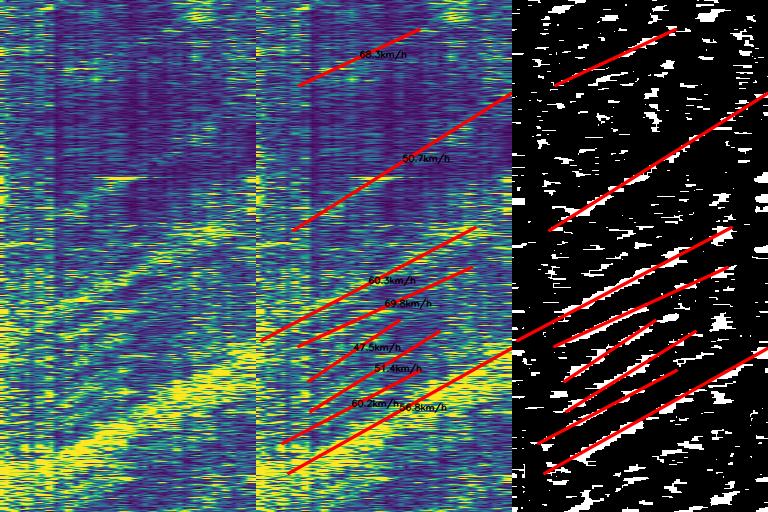

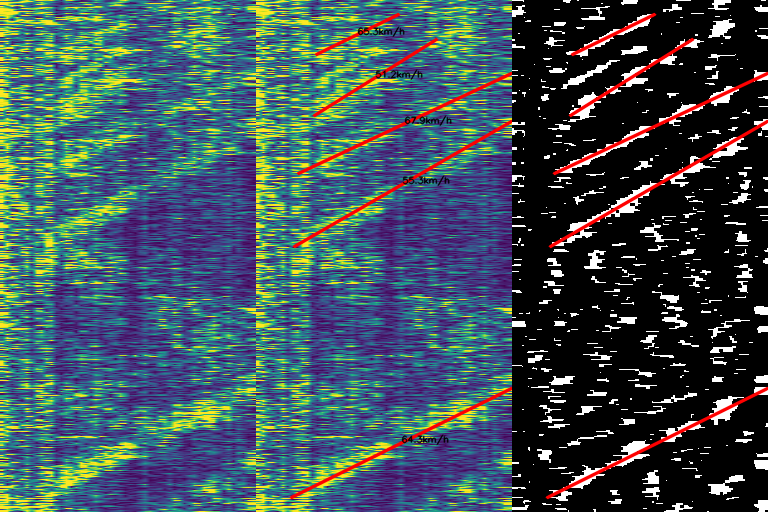

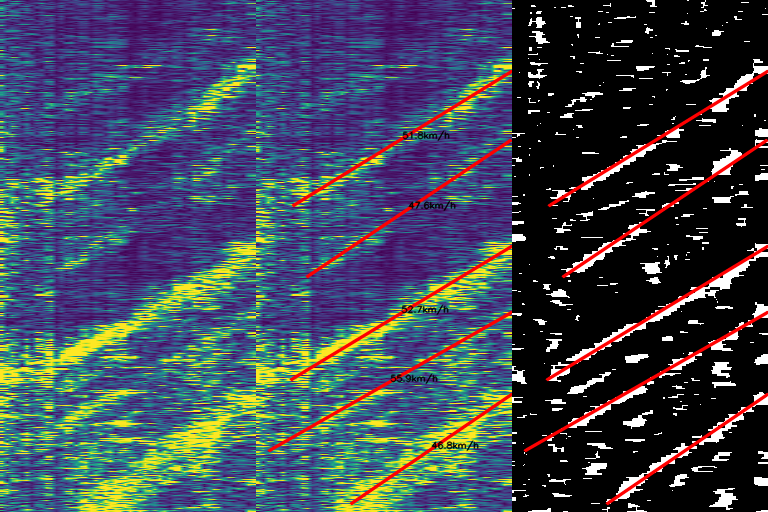

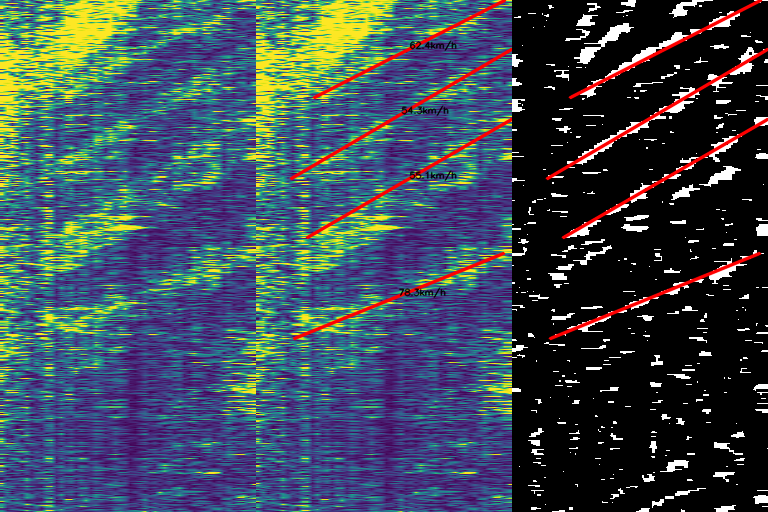

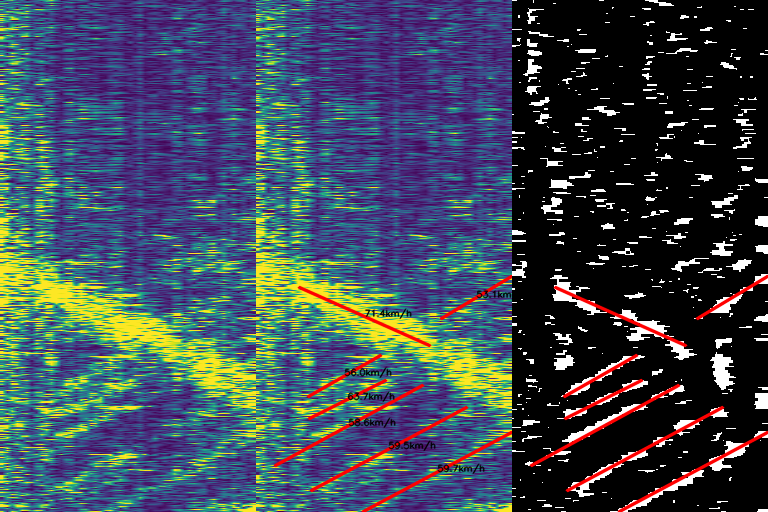

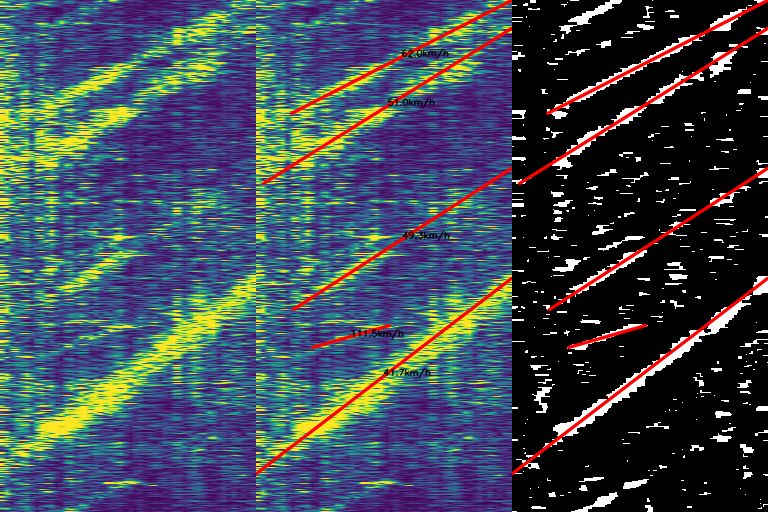

In [75]:
files = [[], [], []]

path_out = 'mateusz\\'
files[0] = glob.glob(path_out+"*")
files[0].sort()

path_out = 'jedrzej\\'
files[1] = glob.glob(path_out+"*")
files[1].sort()

path_out = 'other\\'
files[2] = glob.glob(path_out+"*")
files[2].sort()


dx= 5.106500953873407
dt= 0.0016

# We reapeat all the previous steps on all the images
for file in files:
   for i in range(2):
      data = []

      if i == 0:
         first_filename = file[0]
         for f in file[:6]:
            data.append(np.load(f))
      else:
         first_filename = file[7]
         for f in file[6:12]:
            data.append(np.load(f))
      
      data = np.concatenate(data)
      time_start = datetime.datetime.strptime('2024-05-07 ' + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
      index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

      columns = np.arange(len(data[0])) * dx


      df = pd.DataFrame(data=data, index=index, columns=columns)

      df -= df.mean()
      df = np.abs(df)

      arr = np.array(df)
      arr_orgin = np.copy(arr)

      arr_btrCol = np.copy(arr)
      arr_btrCol = arr + np.median(arr) - np.median(arr, axis=0)
      arr = arr_btrCol

      low, high = np.percentile(df, [3, 99])
      arr[arr > high] = high
      arr[arr < low] = low

      kernel_size = (51, 5)
      kernel = np.ones((kernel_size[0],kernel_size[1])) / (kernel_size[0]*kernel_size[1])
      arr_blurred = cv2.filter2D(arr, kernel=kernel, ddepth=-1)

      kernel_size = (11, 3)
      kernel = np.ones((kernel_size[0],kernel_size[1])) / (kernel_size[0]*kernel_size[1])
      arr_blurred2 = cv2.filter2D(arr_blurred, kernel=kernel, ddepth=-1)

      laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
      img_lapl = cv2.filter2D(arr_blurred2, -1, laplacian)

      img = imshow(img_lapl, False)

      img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 101, 2)

      struct = np.ones((3, 3), np.uint8)
      img = cv2.erode(img, struct, iterations=1)

      process_lines(img, arr_orgin)

It is clear that the program correctly highlights the visible lines in the pictures. It only has some problems in case a line is too wide (in this case laplacian filter might be disadvantageous) and might sometimes fail to detect a short line that changes its value a lot.